In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
import networkx as nx
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
    
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            #why do like this?
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= torch.rand(self._n).to(device)

            #dI = torch.rand(self._n, requires_grad=True).to(device) < dI 
            #random will effect the result, less than operation will lose gradient
            dI_01= dI>dIsample

            dI= dI*(1-I)
            

            I = torch.max(I, dI_01) # got infected

            states[self._states_names['I']] = I

        return states, dI
    
    def ODE(self, time_horizon, degree):
        ODEIs= [1]
        ODEI= 1
        ODES= self._n - ODEI
        dI= 1
        Cvalue= 0
        for i in range(time_horizon):
            #dI= (self._pinf.item()*degree*ODEI*ODES)/(self._n), outer link number
            if i!=0:
                 Cvalue= dI*(degree-1)*(ODES)/(ODES-1+ODEI)+Cvalue*(1-self._pinf.item())*ODES/(ODES-1+dI+1e-8)# nongenerative edge+cross edges
            else:
                 Cvalue= ODEI*degree
            dI= Cvalue*self._pinf.item()
            #dI= self._pinf.item()*ODEI*degree*ODES/self._n
            ODEI+= dI#(generative edges + nongenerative edge)= inner edge, cross edges, outer edge
            ODES-= dI
            if ODES< 0:
                ODES= 0
                ODEI= self._n
            ODEIs.append(ODEI)
        return torch.tensor(ODEIs).to(device)

def sim(time_horizon, population, model, mode="run"):
  log = [population['I']]
  IMeans = [torch.tensor(0).to(device)]
  for i in range(time_horizon):
    population, dI = model(population)
    log.append(population['I'])
    IMeans.append(dI.sum()+IMeans[-1])
  log = torch.stack(log)
  IMeans = torch.stack(IMeans)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log, IMeans


tensor([  1.,  12.,  94., 519., 983., 999., 999., 999., 999., 999., 999., 999.,
        999., 999., 999., 999., 999., 999., 999., 999., 999.],
       grad_fn=<ToCopyBackward0>)


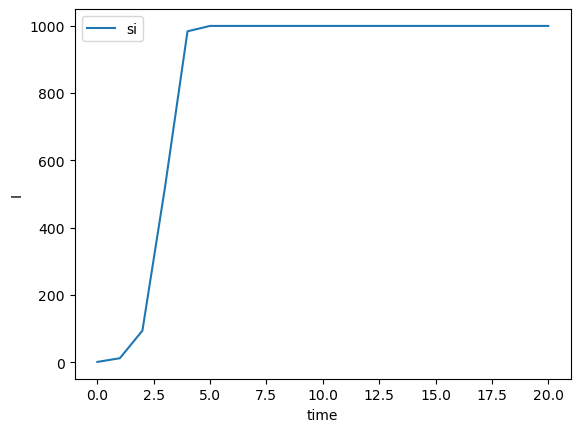

In [9]:
n = 1000 # population
avgDegree = 4  #every individual will have  contacts on average
pinf = 1  #it is the first parameter we are going to fit
time_horizon = 20

#create  dense contacts
graph=nx.dense_gnm_random_graph(n, n*avgDegree)
graph=nx.to_numpy_array(graph)
contacts = torch.FloatTensor(graph).to(device)
contacts = contacts.requires_grad_(True)
#si true 
si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", device=device)
#generate real data
si_result= None
print()
with torch.no_grad():
    population = Population(n, device=device)
    si_result, _ = sim(time_horizon, population, si, mode="run")
#dIs_result= dIs_result.sum(dim=1)
stats_gt   = si_result.sum(dim=3) # si along 20 iterations
stats_gt   = stats_gt.squeeze()
stats_gt_si   = si.ODE(time_horizon, avgDegree*2)
stats_gt.requires_grad_(True)
colors = [("red", 'I')]
age_sizes = [n]
plt.plot(stats_gt.cpu().detach(), label='si')
#plt.plot(stats_gt_si.cpu().detach(), label='ODE')
print(stats_gt.cpu())
plt.xlabel("time")
plt.ylabel("I")
plt.legend()

In [174]:
#si fit
si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", device=device)
#deinfe loss function
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adagrad(si_fit.parameters(), lr=9e-2, weight_decay=1e-2, lr_decay=1e-2)
#optimizer = torch.optim.Adam(si_fit.parameters(), lr=1e-2)

0   0.19900259375572205
1   0.19843247532844543
2   0.19806241989135742
3   0.1979099065065384
4   0.197848841547966
5   0.19837675988674164
6   0.19903211295604706
7   0.199630007147789
8   0.20008091628551483
9   0.20000998675823212
10   0.20067647099494934
11   0.20074419677257538
12   0.20037761330604553
13   0.20028825104236603
14   0.2002427875995636
15   0.2002296894788742
16   0.19998504221439362
17   0.19966042041778564
18   0.1997402310371399
19   0.20012222230434418
20   0.19986961781978607
21   0.19986139237880707
22   0.2001776397228241
23   0.20062477886676788
24   0.2006460577249527
25   0.20120179653167725
26   0.20167887210845947
27   0.20197468996047974
28   0.2022227644920349
29   0.20248045027256012
30   0.20292411744594574
31   0.20359233021736145
32   0.20277735590934753
33   0.2022283971309662
34   0.20195023715496063
35   0.20241960883140564
36   0.20251426100730896
37   0.20239049196243286
38   0.20243294537067413
39   0.20237648487091064
40   0.202744305133819

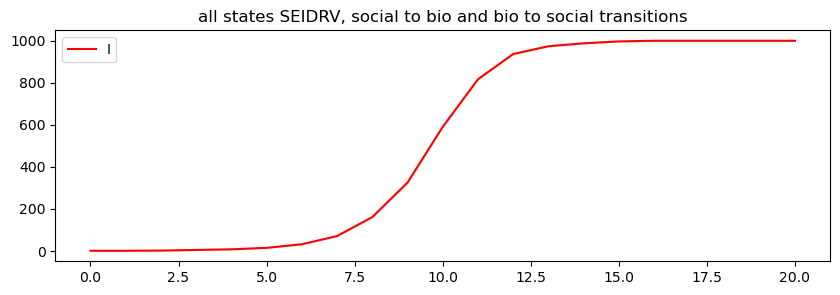

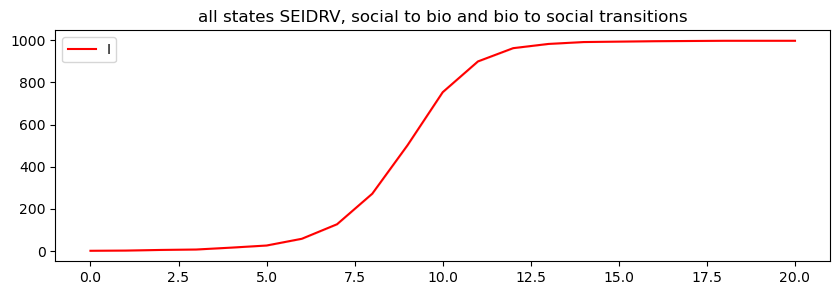

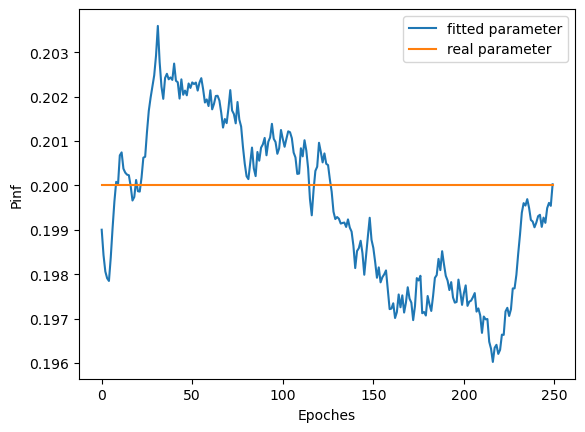

In [178]:
fitPinfs=[]
#gradient direction: negative-> positive
for i in range(250):
    print(i, " ", si_fit._pinf.item())
    optimizer.zero_grad()
    fitPinfs.append(si_fit._pinf.item())
    population = Population(n, device=device)
    si_pred, IMeans_pred = sim(time_horizon, population, si_fit, mode="train")
    loss = loss_fn(stats_gt, IMeans_pred)
    loss.backward(retain_graph=True)
    optimizer.step()

print_model_parameters(si_fit)
plot(si_pred.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plot(si_result.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plt.plot(fitPinfs, label='fitted parameter')
plt.plot([pinf]*len(fitPinfs), label='real parameter')
plt.xlabel("Epoches")
plt.ylabel("Pinf")
plt.legend()
